#Viki Data Challenge: Session Vignettes

#What are mobile users doing on their first day on the app?

####Column Legend:
uuid - Unique user identifiers. A uuid may have multiple as_id associated with it.

as_id - Application session identifiers. Each uuid in this data set should have at least one as_id with an 'install' event that signifies they installed the android app on this day.

time_t - UTC timestamp indicating the time of event. 

as_counter - Application session counters. The as_counter starts at 0 for the first event in a session and increments for each subsequent event

event - Events can represent activites done by the user such as a 'click' or they can represent client activities like 'sv' (screen view).

what - Indicates what a user clicked on, given that the 'click' action occured in this action

page - Indicates what page of the android app the user is on

query - search term a user entered in the search box

video_id - unique video identifiers

####Event Legend:
ad_click = user clicked on an ad

ad_completed = the ad completed

ad_error = the ad had an error

ad_first_quarter = 25% of the ad is completed

ad_loaded = ad loaded successfully and should be ready for ad_started 

ad_mid_point = 50% of the ad is completed

ad_paused = user paused an ad

ad_request = the client makes a request to receive ads (occurs before video_play)

ad_skip = user skipped the ad, some ads allow the user to skip after a few 
seconds

ad_started = ad started

ad_third_quarter = 75% of the ad is completed

click = user clicked on something

error = some error

install = user installed the viki app

lb = light box event, this is a pop-up of some kind

minute_view = every 60s during a video this event is fired, it allows you to count how many minutes a video was watched

registration = user registered

session_start = the video session started

subtitle_change = user changed the subtitle language

succeed = user joined viki pass (payment succeeded)

sv = screen view, this means a new screen (page) was seen by the user timed_comment_change = related to our timed comment feature: http://support.viki.com/hc/en- us/articles/200139124-Timed-Comments

turing_session = this is our A/B testing framework (ignore for the purpose of this analysis) video_blocked = this means the video is not available to the user because of the geographic region they are in

video_load = this means the video is loaded (this must happen prior to video_play)

video_play = this means the video is played




In [3]:
import pandas as pd
import numpy as np
import pylab as plt
from scipy import stats
from scipy.cluster.vq import kmeans, vq,  whiten
from collections import Counter
from sklearn.cross_validation import train_test_split
import sklearn.ensemble as sk
import sklearn.metrics as skm
from scipy.stats.stats import pearsonr

In [4]:
%matplotlib inline

In [21]:
viki = pd.read_csv('/Users/molliepettit/Desktop/Data Science/Projects/Viki/12701720.csv')

/Users/molliepettit/anaconda/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


##General Exploration
From this general exploration, we can see tha that there are 533765 actions catalogued in this data. Every row has a 'uuid', 'as_id', 'time_t', 'as_counter', and 'event', but only some have 'what', 'page', 'query', and 'video_id', as these variables are linked to specific actions.
####Code:

In [4]:
print(viki.head(5))

                                                uuid                    as_id  \
0  com.viki.android_2014011_e3f133fa-8552-479a-a7...  100005a-1405833646-5319   
1  com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...  100005a-1405859525-5958   
2  com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...  100005a-1405859525-5958   
3  com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...  100005a-1405859529-7797   
4  com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...  100005a-1405859529-7797   

                time_t as_counter           event  what          page query  \
0  2014-07-20 05:21:49          0         install  null          null  null   
1  2014-07-20 12:32:06          0         install  null          null  null   
2  2014-07-20 12:32:26          1              sv  null  welcome_page  null   
3  2014-07-20 12:32:26          0   session_start  null          null  null   
4  2014-07-20 12:32:26          1  turing_session  null          null  null   

  video_id  
0     null  
1     null  

In [5]:
print(viki.describe())

                                                     uuid  \
count                                              533765   
unique                                               8067   
top     com.viki.android_GT-S7582_b7df6b0b-0c38-424f-8...   
freq                                                 1299   

                          as_id               time_t as_counter        event  \
count                    533765               533765     533765       533765   
unique                    22604                83320       2076           26   
top     100005a-1405817661-5720  2014-07-20 21:30:29          0  minute_view   
freq                       1044                   34      14315       151920   

          what    page   query video_id  
count   533765  533765  533765   533765  
unique      63      42    3633     2685  
top       null    null    null     null  
freq    481725  340065  527873   190574  


Find number of non-null values for each column:

In [6]:
viki = viki.replace('null', np.nan)

In [565]:
viki.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533765 entries, 0 to 533764
Data columns (total 9 columns):
uuid          533765 non-null object
as_id         533765 non-null object
time_t        533765 non-null object
as_counter    533465 non-null object
event         533765 non-null object
what          52040 non-null object
page          193700 non-null object
query         5892 non-null object
video_id      343191 non-null object
dtypes: object(9)
memory usage: 40.7+ MB


In [465]:
viki

,uuid,as_id,time_t,as_counter,event,what,page,query,video_id
0,com.viki.android_2014011_e3f133fa-8552-479a-a7...,100005a-1405833646-5319,2014-07-20 05:21:49,0,install,NaN,NaN,NaN,NaN
1,com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...,100005a-1405859525-5958,2014-07-20 12:32:06,0,install,NaN,NaN,NaN,NaN
2,com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...,100005a-1405859525-5958,2014-07-20 12:32:26,1,sv,NaN,welcome_page,NaN,NaN
3,com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...,100005a-1405859529-7797,2014-07-20 12:32:26,0,session_start,NaN,NaN,NaN,NaN
4,com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...,100005a-1405859529-7797,2014-07-20 12:32:26,1,turing_session,NaN,NaN,NaN,NaN
5,com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...,100005a-1405859529-7797,2014-07-20 12:32:27,2,click,play_btn,welcome_page_2,NaN,NaN
6,com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...,100005a-1405859529-7797,2014-07-20 12:32:27,3,click,sign_up_btn,welcome_page_2,NaN,NaN
7,com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...,100005a-1405859529-7797,2014-07-20 12:32:27,4,sv,NaN,cta_page,NaN,NaN
8,com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...,100005a-1405859529-7797,2014-07-20 12:32:46,5,click,skip_btn,welcome_page_2,NaN,NaN
9,com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...,100005a-1405859529-7797,2014-07-20 12:32:46,6,sv,NaN,home,NaN,NaN


##What is the Last Action Taken before Users End their Session?

The last_actions for each session (as_id) is listed below in descending order:

In [16]:
last_event_sorted

,Last_Event,Count
10,sv,18063
2,minute_view,1022
7,turing_session,1016
0,ad_error,658
22,click,616
4,install,334
5,video_play,210
15,ad_paused,141
21,ad_request,115
20,ad_loaded,109


As one can see, The top last event per unique session is 'sv', or screen view. Each 'sv' action has an associated 'page'; therefore, I found the most common pages users saw last before exiting their sessions (below)

In [596]:
last_page_sorted

,Last_Page,Count
13,welcome_page,7858
15,home,5656
0,NaN,3925
27,cta_page,1444
25,tv_index_page,735
8,video_page_portrait,615
6,movie_index_page,532
3,container_page,338
2,search_page,313
16,sign_up_page,247


####Code:

In [8]:
unique_as_ids = (viki["as_id"].unique())
len(unique_as_ids)

22604

In [9]:
unique_pages = (viki["page"].unique())

In [10]:
last_event = []
last_page = []
user_id = []
for id in unique_as_ids:
    user_events = list(viki['event'][viki['as_id'] == id])
    last_event.append(user_events[-1])
    user_page = list(viki['page'][viki['as_id'] == id])
    last_page.append(user_page[-1])
    if id not in user_id:
        user_id.append(id)

In [11]:
Counter(last_event)

Counter({'sv': 18063, 'minute_view': 1022, 'turing_session': 1016, 'ad_error': 658, 'click': 616, 'install': 334, 'video_play': 210, 'ad_paused': 141, 'ad_request': 115, 'ad_loaded': 109, 'ad_skip': 61, 'video_load': 57, 'session_start': 57, 'ad_completed': 56, 'registration': 28, 'ad_started': 23, 'ad_first_quarter': 8, 'ad_third_quarter': 8, 'ad_mid_point': 7, 'timed_comment_change': 6, 'subtitle_change': 6, 'lb': 2, 'ad_click': 1})

In [12]:
last_event_dict = Counter(last_event)

key = []
val = []
for k, v in last_event_dict.items():
    key.append(k)
    val.append(v)
    
key2pd = pd.Series(key, name='Last_Event')
val2pd = pd.Series(val, name='Count')
count = pd.concat([key2pd, val2pd], axis=1)
last_event_sorted = count.sort(['Count'], ascending = [False])


In [13]:
Counter(last_page)

Counter({'welcome_page': 7858, 'home': 5656, nan: 3925, 'cta_page': 1444, 'tv_index_page': 735, 'video_page_portrait': 615, 'movie_index_page': 532, 'container_page': 338, 'search_page': 313, 'sign_up_page': 247, 'welcome_page_2': 162, 'login_page': 157, 'tv_list_page': 138, 'profile_page': 101, 'movie_list_page': 56, 'news_index_page': 51, 'vp_exclusives_page': 47, 'account_settings_page': 41, 'vikipass_page': 38, 'search_results_page': 25, 'forgot_password_page': 25, 'container_langauges_page': 23, 'comment_and_share_page': 22, 'share_page': 20, 'video_player_landscape': 18, 'home_page': 11, 'tv_channel': 5, 'movie_video': 1})

In [14]:
last_page_dict = Counter(last_page)

key = []
val = []
for k, v in last_page_dict.items():
    key.append(k)
    val.append(v)
    
key2pd = pd.Series(key, name='Last_Page')
val2pd = pd.Series(val, name='Count')
count = pd.concat([key2pd, val2pd], axis=1)
last_page_sorted = count.sort(['Count'], ascending = [False])

##What occured right before the error?

There is one occurance of an 'error' event in this data set. It is helpful to know what leads to errors, so I have found what the user did leading up to this error (below)

In [598]:
viki.iloc[322132:322134]

,uuid,as_id,time_t,as_counter,event,what,page,query,video_id
322132,com.viki.android_Nexus 7_a04a09a1-20de-4a03-bf...,100005a-1405820262-6068,2014-07-20 01:42:01,12,sv,NaN,login_page,NaN,NaN
322133,com.viki.android_Nexus 7_a04a09a1-20de-4a03-bf...,100005a-1405820262-6068,2014-07-20 01:42:28,13,error,vikipass_subscription,NaN,NaN,NaN


####Code:

In [466]:
viki[viki['event']=='error']

,uuid,as_id,time_t,as_counter,event,what,page,query,video_id
322133,com.viki.android_Nexus 7_a04a09a1-20de-4a03-bf...,100005a-1405820262-6068,2014-07-20 01:42:28,13,error,vikipass_subscription,NaN,NaN,NaN


##Find max actions per session per user, total actions per user, and average actions per session per user

In [26]:
for column in viki:
    print(column, viki[column].dtypes)

uuid object
as_id object
time_t object
as_counter object
event object
what object
page object
query object
video_id object


Must change as_counter to a float type to be able to do mathematical calculations

In [7]:
viki['as_counter'] = viki['as_counter'].astype(float)

In [97]:
max(viki['as_counter'])

1080.0

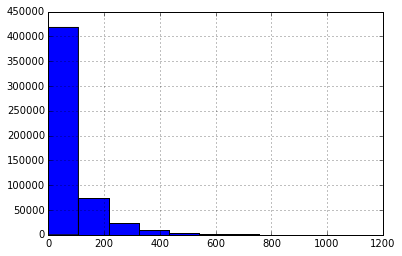

In [38]:
(viki['as_counter']).hist()

Doesn't tell us much... Need to find max per user.

In [ ]:
user_id = []
max_count = []
sum_count = []
for id in unique_ids:
    user_counts = viki['as_counter'][viki['uuid'] == id]
    max_count.append(max(user_counts))
    sum_count.append(sum(user_counts))
    if id not in user_id:
        user_id.append(id)

In [169]:
id2pd = pd.Series(user_id, name='id')
max2pd = pd.Series(max_count, name='count_per_sesh')
user_count = pd.concat([id2pd, max2pd], axis=1)

In [167]:
user_count['count_total'] = sum_count

In [32]:
user_count['avg_per_sesh'] = user_count['count_total'] / user_count['count_per_sesh']

In [34]:
user_count = user_count.replace(np.nan, 0)

In [578]:
len(viki["as_id"][viki['uuid']=='com.viki.android_202F_12a48290-106a-473c-a680-5297a2e44c08'].unique())

3

In [35]:
user_id = []
sessions_per_user = []
for id in unique_ids:
    sessions_per_user.append(len(viki["as_id"][viki['uuid']==id].unique()))
#     unique_as_ids = viki["as_id"][viki['uuid']==id].unique()
#     sessions_per_user.append(len(unique_as_ids))
    if id not in user_id:
        user_id.append(id)
    

In [36]:
id2pd = pd.Series(user_id, name='id')
sesh2pd = pd.Series(sessions_per_user, name='Sessions')
sessions = pd.concat([id2pd, sesh2pd], axis=1).set_index('id')

In [37]:
user_table = user_count.join(sessions)

In [39]:
user_table['avg_per_sesh'] = user_table['count_total'] / user_table['sessions']

In [46]:
user_table

,max_sesh_count,count_total,sessions,avg_per_sesh
id,,,,
com.viki.android_2014011_e3f133fa-8552-479a-a7d0-d580d13825e9,0,0,1,0.000000
com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-37efc20e3401,25,286,2,143.000000
com.viki.android_202F_12a48290-106a-473c-a680-5297a2e44c08,26,326,3,108.666667
com.viki.android_304SH_1284d768-fead-4c22-a317-454d57e24372,13,92,2,46.000000
com.viki.android_5038E_ed564b2e-fe09-4167-8424-72f2b2104124,167,23885,9,2653.888889
com.viki.android_6036Y_128aa2eb-918a-401c-a21a-1122d945149e,61,1744,2,872.000000
com.viki.android_6037Y_2dfdcfb9-39ee-4c98-a2fc-702a44265d54,10,56,2,28.000000
com.viki.android_7040T_ba3e8a93-3701-4bb1-9c3b-7d2f25f73426,237,27611,2,13805.500000
com.viki.android_831C_2c08462d-a3e0-4abf-935a-b273a943e09d,10,56,2,28.000000


In [45]:
user_table.to_csv('user_table.csv')

In [26]:
print('The maximum user count in one session is:', max(user_count_per_session['count']))
print('The median user count in one session is:', np.median(user_count_per_session['count']))
print('The mode user count in one session is:', stats.mode(user_count_per_session['count'])[0][0],'with a frequency of:', stats.mode(user_count_per_session['count'])[1][0])

The maximum user count in one session is: 1080.0
The median user count in one session is: 22.0
The mode user count in one session is: 5.0 with a frequency of: 392.0


In [39]:
print('The maximum total user count is:', max(user_count['count_total']))
print('The median total user count is:', np.median(user_count['count_total']))
print('The mode total user count is:', stats.mode(user_count['count_total'])[0][0],'with a frequency of:', stats.mode(user_count['count_total'])[1][0])

The maximum total user count is: 559259.0
The median total user count is: 254.0
The mode total user count is: 16.0 with a frequency of: 334.0


In [58]:
print('The maximum Avg per session is:', max(user_count['avg_per_sesh']))
print('The median Avg per session is:', np.median(user_count['avg_per_sesh']))
print('The mode Avg per session is:', stats.mode(user_count['avg_per_sesh'])[0][0],'with a frequency of:', stats.mode(user_count['avg_per_sesh'])[1][0])

The maximum Avg per session is: 517.832407407
The median Avg per session is: 11.68
The mode Avg per session is: 3.2 with a frequency of: 329.0


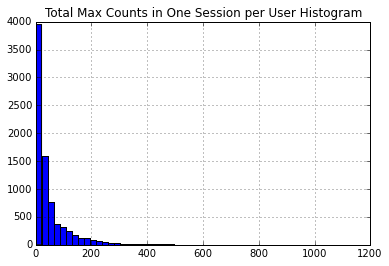

In [21]:
(user_count['count_per_sesh']).hist(bins=50)
plt.title('Total Max Counts in One Session per User Histogram')

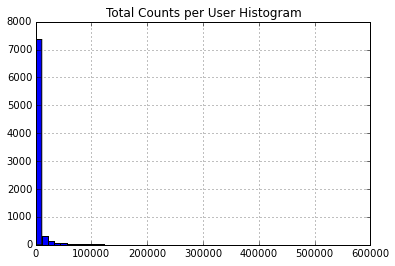

In [59]:
(user_count['count_total']).hist(bins=50)
plt.title('Total Counts per User Histogram')

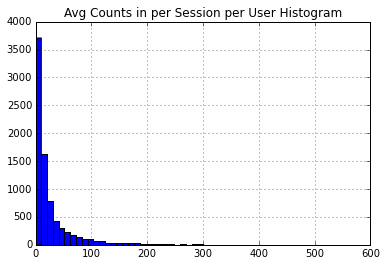

In [60]:
(user_count['avg_per_sesh']).hist(bins=50)
plt.title('Avg Counts in per Session per User Histogram')

In [30]:
# user_count=user_count.rename(columns = {'count':'count_per_sesh'})

In [4]:
# from IPython.html.widgets import FloatProgress
# from IPython.display import display
# from time import sleep
# f = FloatProgress(min=0, max=100)
# display(f)
# for i in range(100):
#    sleep(0.1)
#    f.value = i

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [ ]:
# cluster1 = (user_count['count']).values

# average_distance = []
# for k in range(1,6):
#     cluster1 = whiten(cluster1)
#     centroids1,dist1 = kmeans(cluster1,k) # you can calculate the eucledean distance in the next line
#     idx1,idxdist1 = vq(cluster1,centroids1)
#     avg_dist = np.mean(idxdist1)
#     average_distance.append(avg_dist)
#     f.value = k
# # Just plotting the mean distance, you can plot Euclidian distance once you update the code
# plot(range(1,11), average_distance)

##Find top events, queries, whats, pages, and videos

In [105]:
event_dict = Counter(viki['event'])
key = []
val = []
for k, v in event_dict.items():
    key.append(k)
    val.append(v)

In [475]:
key2pd = pd.Series(key, name='event')
val2pd = pd.Series(val, name='count')
what_count = pd.concat([key2pd, val2pd], axis=1)
what_count.sort(['count'], ascending = [False])

,event,count
15,minute_view,151920
25,sv,141666
21,click,52034
23,ad_request,35853
14,ad_error,20366
17,video_load,18017
10,ad_loaded,16322
3,ad_started,16267
5,video_play,12105
0,session_start,11392


In [479]:
import pylab as pl
import numpy as np



TypeError: 'dict_keys' object does not support indexing

TypeError: 'dict_keys' object does not support indexing

In [99]:
query_dict = Counter(viki['query'])
key = []
val = []
for k, v in query_dict.items():
    key.append(k)
    val.append(v)

In [100]:
key2pd = pd.Series(key, name='query')
val2pd = pd.Series(val, name='count')
what_count = pd.concat([key2pd, val2pd], axis=1)
what_count.sort(['count'], ascending = [False])

,query,count
0,NaN,527873
2535,the heirs,108
1966,heirs,43
1570,my love from the star,41
3476,hotel king,40
3232,running man,37
1205,anime,35
1216,roommate,33
1848,sex,24
2935,to the beautiful you,23


In [487]:
what_dict = Counter(viki['what'])

In [488]:
key = []
val = []
for k, v in what_dict.items():
    key.append(k)
    val.append(v)

In [493]:
key2pd = pd.Series(key, name='what')
val2pd = pd.Series(val, name='count')
what_count = pd.concat([key2pd, val2pd], axis=1)
what_sorted = what_count.sort(['count'], ascending = [False])
what_sorted

,what,count
0,NaN,481725
10,skip_btn,7572
61,episodes,6116
51,submit_query,5892
24,sign_up_btn,5059
13,watch_now,4670
20,popular_tv,2697
42,autocomplete,2224
34,masthead,1784
2,languages_tab,1605


In [494]:
page_dict = Counter(viki['page'])

In [497]:
key = []
val = []
for k, v in page_dict.items():
    key.append(k)
    val.append(v)

In [499]:
key2pd = pd.Series(key, name='page')
val2pd = pd.Series(val, name='count')
page_count = pd.concat([key2pd, val2pd], axis=1)
page_sorted = page_count.sort(['count'], ascending = [False])
page_sorted

,page,count
0,NaN,340065
23,home,65620
12,video_page_portrait,19891
2,search_page,17622
4,video_player_landscape,16016
3,container_page,14211
41,cta_page,8845
11,welcome_page_2,8587
22,welcome_page,7977
35,search_results_page,7280


In [501]:
video_id_dict = Counter(viki['video_id'])

In [502]:
key = []
val = []
for k, v in video_id_dict.items():
    key.append(k)
    val.append(v)

In [503]:
key2pd = pd.Series(key, name='video_id')
val2pd = pd.Series(val, name='count')
video_count = pd.concat([key2pd, val2pd], axis=1)
video_sorted = video_count.sort(['count'], ascending = [False])
video_sorted

,video_id,count
0,NaN,190574
1026,1045294v,8756
973,44699v,6597
2521,1044095v,6593
2126,1044345v,4741
595,1044267v,4429
2018,1045208v,4254
43,1044780v,3597
2134,44943v,3568
28,1044346v,3468


In [114]:
install_count = sum(viki['event'] == 'install')
install_count

8115

##Create Loop to find, for each user, how many of each event they participated in
Still working on this...

In [33]:
unique_ids = (viki["uuid"].unique())

In [34]:
unique_events = (viki["event"].unique())

In [122]:
user_count

,id,count_per_sesh,count_total,avg_per_sesh,install,sv,session_start,turing_session,click,video_load,...,ad_mid_point,ad_third_quarter,ad_completed,timed_comment_change,ad_click,lb,subtitle_change,video_blocked,succeed,error
0,com.viki.android_2014011_e3f133fa-8552-479a-a7...,0,0,0.000000,8115,141666,11392,11008,52034,18017,...,4572,4172,4857,1133,176,243,866,35,5,1
1,com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...,25,286,11.440000,8115,141666,11392,11008,52034,18017,...,4572,4172,4857,1133,176,243,866,35,5,1
2,com.viki.android_202F_12a48290-106a-473c-a680-...,26,326,12.538462,8115,141666,11392,11008,52034,18017,...,4572,4172,4857,1133,176,243,866,35,5,1
3,com.viki.android_304SH_1284d768-fead-4c22-a317...,13,92,7.076923,8115,141666,11392,11008,52034,18017,...,4572,4172,4857,1133,176,243,866,35,5,1
4,com.viki.android_5038E_ed564b2e-fe09-4167-8424...,167,23885,143.023952,8115,141666,11392,11008,52034,18017,...,4572,4172,4857,1133,176,243,866,35,5,1
5,com.viki.android_6036Y_128aa2eb-918a-401c-a21a...,61,1744,28.590164,8115,141666,11392,11008,52034,18017,...,4572,4172,4857,1133,176,243,866,35,5,1
6,com.viki.android_6037Y_2dfdcfb9-39ee-4c98-a2fc...,10,56,5.600000,8115,141666,11392,11008,52034,18017,...,4572,4172,4857,1133,176,243,866,35,5,1
7,com.viki.android_7040T_ba3e8a93-3701-4bb1-9c3b...,237,27611,116.502110,8115,141666,11392,11008,52034,18017,...,4572,4172,4857,1133,176,243,866,35,5,1
8,com.viki.android_831C_2c08462d-a3e0-4abf-935a-...,10,56,5.600000,8115,141666,11392,11008,52034,18017,...,4572,4172,4857,1133,176,243,866,35,5,1
9,com.viki.android_831C_756ab161-f8ba-470a-86a0-...,9,46,5.111111,8115,141666,11392,11008,52034,18017,...,4572,4172,4857,1133,176,243,866,35,5,1


#Other things I can find
    -What is the last thing they did before they ended their session?
    -Totes need more visualizations

In [148]:
# viki.groupby(['uuid', 'event']).aggregate({'event':'count'})

# data = pd.read_csv('scrubbed_data.csv', usecols = ['col_1', 'col_2', 'col_3'])
# cd1 = pd.tools.pivot.pivot_table(data = viki[['uuid', 'event']], values = 'event', index = 'uuid', columns = 'event', aggfunc=lambda x: len(x.unique()))
# cd1
# cd1.to_csv('pivot.csv')

# port_stats = titanic_survival.pivot_table(index='embarked', values=['age', 'survived', 'fare'], aggfunc=np.mean)
# print(port_stats)

# df = pd.read_clipboard()

# unique_counts = viki.groupby(['uuid', 'event'])['event'].unique().map(len)
# unstacked = unique_counts.unstack(level='event').fillna(0)

In [211]:
viki_user_event = viki[['uuid', 'event']]
viki_user_event

,uuid,event
0,com.viki.android_2014011_e3f133fa-8552-479a-a7...,install
1,com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...,install
2,com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...,sv
3,com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...,session_start
4,com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...,turing_session
5,com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...,click
6,com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...,click
7,com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...,sv
8,com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...,click
9,com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-...,sv


In [215]:
event_per_user = pd.pivot_table(viki_user_event, index='uuid', columns='event',aggfunc=len, fill_value=0) 

In [216]:
event_per_user

event,ad_click,ad_completed,ad_error,ad_first_quarter,ad_loaded,ad_mid_point,ad_paused,ad_request,ad_skip,ad_started,...,registration,session_start,subtitle_change,succeed,sv,timed_comment_change,turing_session,video_blocked,video_load,video_play
uuid,,,,,,,,,,,,,,,,,,,,,
com.viki.android_2014011_e3f133fa-8552-479a-a7d0-d580d13825e9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-37efc20e3401,0,0,1,0,1,0,0,2,0,0,...,0,1,0,0,12,0,1,0,1,1
com.viki.android_202F_12a48290-106a-473c-a680-5297a2e44c08,0,0,1,0,1,0,0,2,0,0,...,0,1,0,0,18,0,1,0,1,1
com.viki.android_304SH_1284d768-fead-4c22-a317-454d57e24372,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,11,0,1,0,0,0
com.viki.android_5038E_ed564b2e-fe09-4167-8424-72f2b2104124,0,0,28,3,22,1,2,47,18,19,...,1,2,0,0,64,0,1,0,26,13
com.viki.android_6036Y_128aa2eb-918a-401c-a21a-1122d945149e,0,0,4,0,5,0,0,9,0,0,...,1,1,0,0,21,0,1,0,5,2
com.viki.android_6037Y_2dfdcfb9-39ee-4c98-a2fc-702a44265d54,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,8,0,1,0,0,0
com.viki.android_7040T_ba3e8a93-3701-4bb1-9c3b-7d2f25f73426,0,12,13,9,10,8,4,19,2,12,...,0,1,0,0,56,0,1,0,10,5
com.viki.android_831C_2c08462d-a3e0-4abf-935a-b273a943e09d,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,9,0,1,0,0,0


In [217]:
list(event_per_user.columns.values)

['ad_click',
 'ad_completed',
 'ad_error',
 'ad_first_quarter',
 'ad_loaded',
 'ad_mid_point',
 'ad_paused',
 'ad_request',
 'ad_skip',
 'ad_started',
 'ad_third_quarter',
 'click',
 'error',
 'install',
 'lb',
 'minute_view',
 'registration',
 'session_start',
 'subtitle_change',
 'succeed',
 'sv',
 'timed_comment_change',
 'turing_session',
 'video_blocked',
 'video_load',
 'video_play']

In [218]:
# frames = [user_count_idsort, event_per_user_idsort]
# user_table = pd.concat(frames)
user_table = user_count_idsort.join(event_per_user)
user_table

,count_per_sesh,count_total,avg_per_sesh,ad_click,ad_completed,ad_error,ad_first_quarter,ad_loaded,ad_mid_point,ad_paused,...,registration,session_start,subtitle_change,succeed,sv,timed_comment_change,turing_session,video_blocked,video_load,video_play
id,,,,,,,,,,,,,,,,,,,,,
com.viki.android_2014011_e3f133fa-8552-479a-a7d0-d580d13825e9,0,0,0.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-37efc20e3401,25,286,11.440000,0,0,1,0,1,0,0,...,0,1,0,0,12,0,1,0,1,1
com.viki.android_202F_12a48290-106a-473c-a680-5297a2e44c08,26,326,12.538462,0,0,1,0,1,0,0,...,0,1,0,0,18,0,1,0,1,1
com.viki.android_304SH_1284d768-fead-4c22-a317-454d57e24372,13,92,7.076923,0,0,0,0,0,0,0,...,1,1,0,0,11,0,1,0,0,0
com.viki.android_5038E_ed564b2e-fe09-4167-8424-72f2b2104124,167,23885,143.023952,0,0,28,3,22,1,2,...,1,2,0,0,64,0,1,0,26,13
com.viki.android_6036Y_128aa2eb-918a-401c-a21a-1122d945149e,61,1744,28.590164,0,0,4,0,5,0,0,...,1,1,0,0,21,0,1,0,5,2
com.viki.android_6037Y_2dfdcfb9-39ee-4c98-a2fc-702a44265d54,10,56,5.600000,0,0,0,0,0,0,0,...,0,1,0,0,8,0,1,0,0,0
com.viki.android_7040T_ba3e8a93-3701-4bb1-9c3b-7d2f25f73426,237,27611,116.502110,0,12,13,9,10,8,4,...,0,1,0,0,56,0,1,0,10,5
com.viki.android_831C_2c08462d-a3e0-4abf-935a-b273a943e09d,10,56,5.600000,0,0,0,0,0,0,0,...,0,1,0,0,9,0,1,0,0,0


In [219]:
list(user_table.columns.values)

['count_per_sesh',
 'count_total',
 'avg_per_sesh',
 'ad_click',
 'ad_completed',
 'ad_error',
 'ad_first_quarter',
 'ad_loaded',
 'ad_mid_point',
 'ad_paused',
 'ad_request',
 'ad_skip',
 'ad_started',
 'ad_third_quarter',
 'click',
 'error',
 'install',
 'lb',
 'minute_view',
 'registration',
 'session_start',
 'subtitle_change',
 'succeed',
 'sv',
 'timed_comment_change',
 'turing_session',
 'video_blocked',
 'video_load',
 'video_play']

In [445]:
for event in event_per_user:
    print(event,':',sum(user_table[event]))

ad_click : 176
ad_completed : 4857
ad_error : 20366
ad_first_quarter : 6406
ad_loaded : 16322
ad_mid_point : 4572
ad_paused : 3327
ad_request : 35853
ad_skip : 11359
ad_started : 16267
ad_third_quarter : 4172
click : 52034
error : 1
install : 8115
lb : 243
minute_view : 151920
registration : 1548
session_start : 11392
subtitle_change : 866
succeed : 5
sv : 141666
timed_comment_change : 1133
turing_session : 11008
video_blocked : 35
video_load : 18017
video_play : 12105


In [469]:
print('Percentage of loaded ads that are completed:',sum(event_per_user['ad_completed']) / sum(event_per_user['ad_loaded']))

Percentage of loaded ads that are completed: 0.297573826737


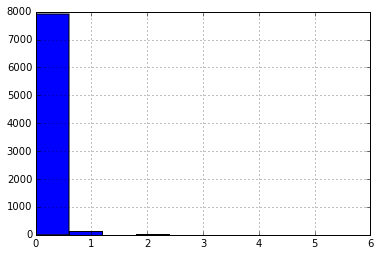

In [519]:
(user_table['ad_click']).hist()

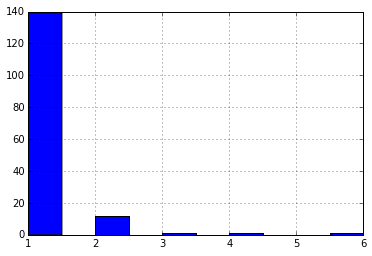

In [522]:
((user_table['ad_click']).replace(0,np.nan)).hist(bins = 20)

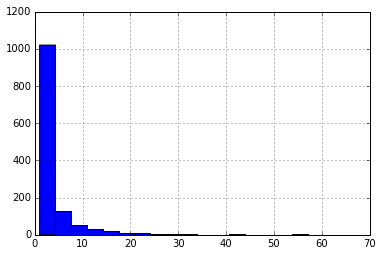

In [525]:
((user_table['ad_completed']).replace(0,np.nan)).hist(bins = 20)

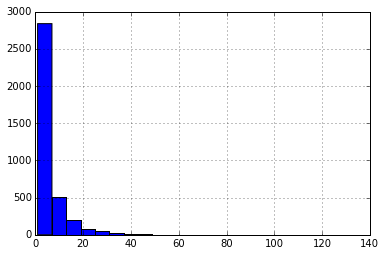

In [527]:
((user_table['ad_error']).replace(0,np.nan)).hist(bins = 20)

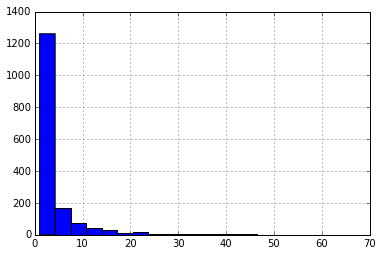

In [528]:
((user_table['ad_first_quarter']).replace(0,np.nan)).hist(bins = 20)

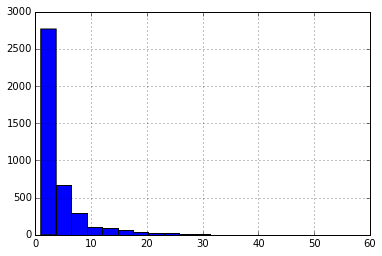

In [529]:
((user_table['ad_loaded']).replace(0,np.nan)).hist(bins = 20)

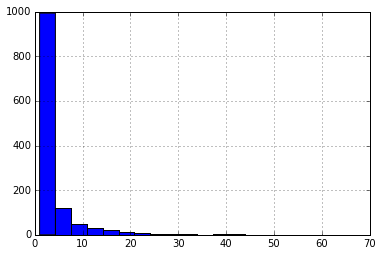

In [531]:
((user_table['ad_mid_point']).replace(0,np.nan)).hist(bins = 20)

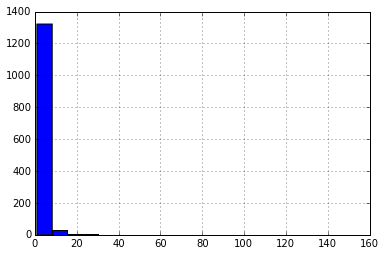

In [532]:
((user_table['ad_paused']).replace(0,np.nan)).hist(bins = 20)

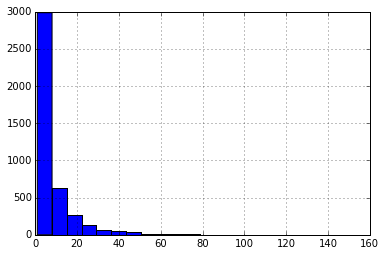

In [533]:
((user_table['ad_request']).replace(0,np.nan)).hist(bins = 20)

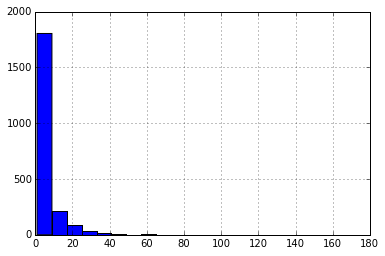

In [534]:
((user_table['ad_skip']).replace(0,np.nan)).hist(bins = 20)

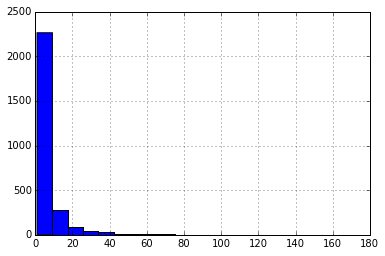

In [535]:
((user_table['ad_started']).replace(0,np.nan)).hist(bins = 20)

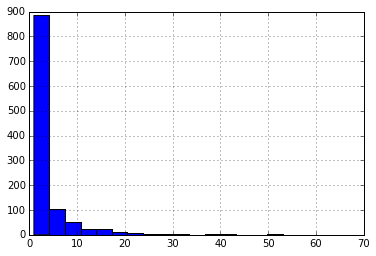

In [536]:
((user_table['ad_third_quarter']).replace(0,np.nan)).hist(bins = 20)

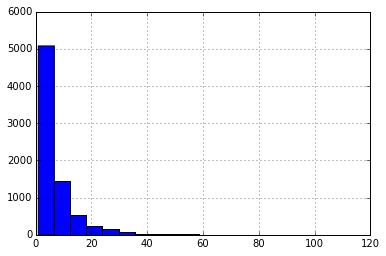

In [537]:
((user_table['click']).replace(0,np.nan)).hist(bins = 20)

(0.0, 1.0, 0, 20)

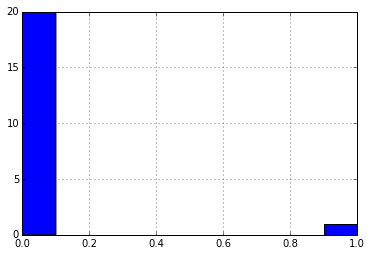

In [566]:
(user_table['error']).hist()
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,20))

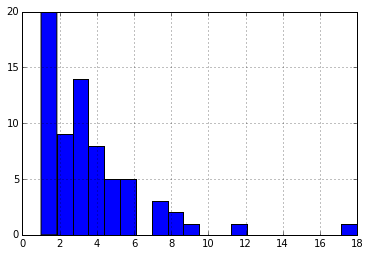

In [541]:
((user_table['lb']).replace(0,np.nan)).hist(bins = 20)

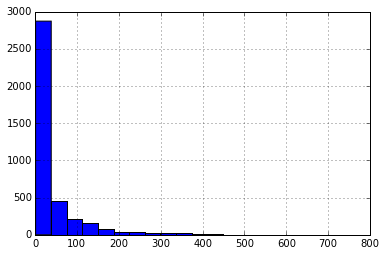

In [542]:
((user_table['minute_view']).replace(0,np.nan)).hist(bins = 20)

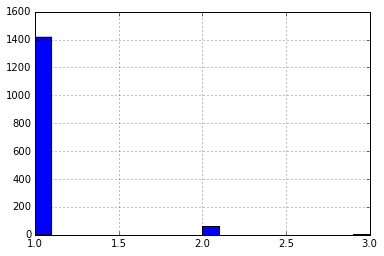

In [543]:
((user_table['registration']).replace(0,np.nan)).hist(bins = 20)

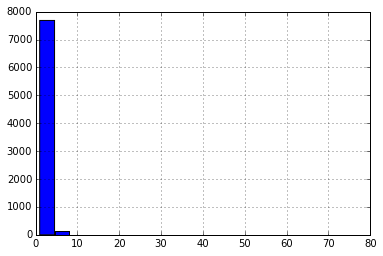

In [544]:
((user_table['session_start']).replace(0,np.nan)).hist(bins = 20)

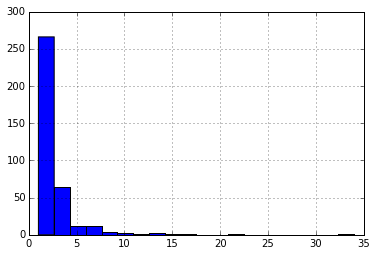

In [545]:
((user_table['subtitle_change']).replace(0,np.nan)).hist(bins = 20)

(0.0, 1.0, 0, 20)

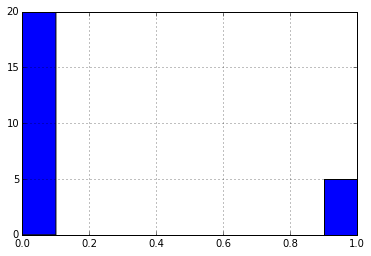

In [547]:
(user_table['succeed']).hist()
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,20))

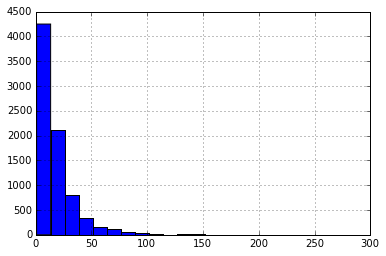

In [548]:
((user_table['sv']).replace(0,np.nan)).hist(bins = 20)

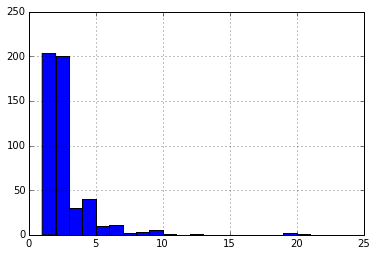

In [549]:
((user_table['timed_comment_change']).replace(0,np.nan)).hist(bins = 20)

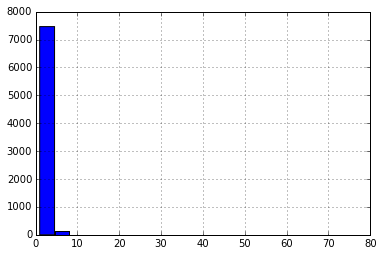

In [550]:
((user_table['turing_session']).replace(0,np.nan)).hist(bins = 20)


# (user_table['turing_session']).hist()
# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,30))

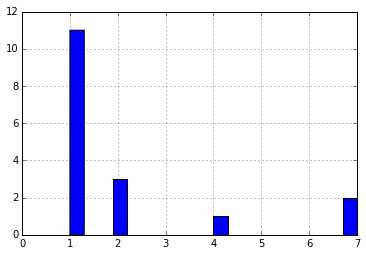

In [551]:
((user_table['video_blocked']).replace(0,np.nan)).hist(bins = 20)


# (user_table['video_blocked']).hist()
# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,150))

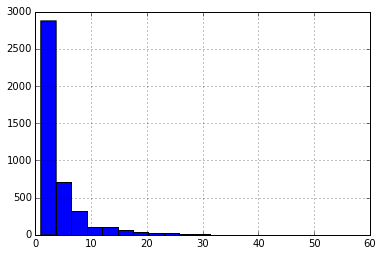

In [552]:
((user_table['video_load']).replace(0,np.nan)).hist(bins = 20)


# (user_table['video_load']).hist()
# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,800))

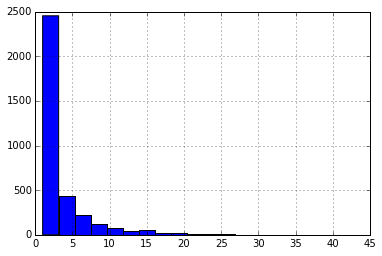

In [553]:
((user_table['video_play']).replace(0,np.nan)).hist(bins = 20)



# (user_table['video_play']).hist()
# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,500))

In [341]:
list(user_table.columns.values)


['count_per_sesh',
 'count_total',
 'avg_per_sesh',
 'ad_click',
 'ad_completed',
 'ad_error',
 'ad_first_quarter',
 'ad_loaded',
 'ad_mid_point',
 'ad_paused',
 'ad_request',
 'ad_skip',
 'ad_started',
 'ad_third_quarter',
 'click',
 'error',
 'install',
 'lb',
 'minute_view',
 'registration',
 'session_start',
 'subtitle_change',
 'succeed',
 'sv',
 'timed_comment_change',
 'turing_session',
 'video_blocked',
 'video_load',
 'video_play',
 'cluster']

In [244]:
from IPython.html.widgets import FloatProgress
from IPython.display import display
from time import sleep
f = FloatProgress(min=0, max=100)
display(f)
for i in range(100):
   sleep(0.1)
   f.value = i

:0: FutureWarning: IPython widgets are experimental and may change in the future.


##Classify Users as High-level, Moderate-level, Low-level, or Very-low-level Users

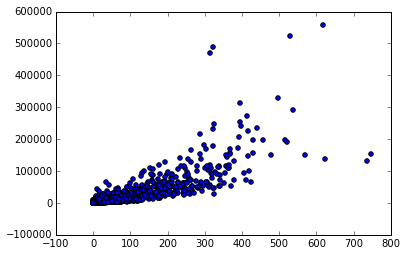

In [235]:
plt.scatter(user_table['minute_view'], user_table['count_total'])

In [260]:
from pylab import plot,show,ylabel,xlabel,title

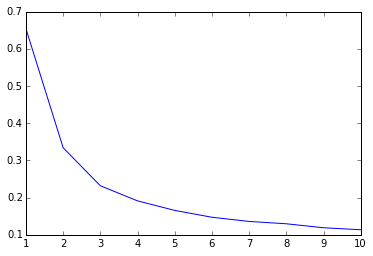

In [251]:
cluster1 = user_table[['minute_view', 'count_total']].values
average_distance = []
for k in range(1,11):
    cluster1 = whiten(cluster1)
    centroids1,dist1 = kmeans(cluster1,k) # you can calculate the eucledean distance in the next line
    idx1,idxdist1 = vq(cluster1,centroids1)
    avg_dist = np.mean(idxdist1)
    average_distance.append(avg_dist)
    f.value = k
# Just plotting the mean distance, you can plot Euclidian distance once you update the code
plot(range(1,11), average_distance)

In [311]:
cluster1 = whiten(cluster1)
centroids1,dist1 = kmeans(cluster1,4)
idx1,idxdist1 = vq(cluster1,centroids1)

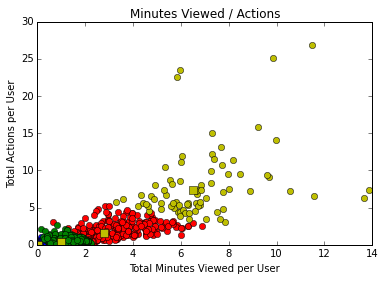

In [331]:
plot(cluster1[idx1==0,0],cluster1[idx1==0,1],'ob',
     cluster1[idx1==1,0],cluster1[idx1==1,1],'or',
     cluster1[idx1==2,0],cluster1[idx1==2,1],'og',
     cluster1[idx1==3,0],cluster1[idx1==3,1],'oy')
plot(centroids1[:,0],centroids1[:,1],'sy',markersize=8)
plt.ylabel('Total Actions per User')
plt.xlabel('Total Minutes Viewed per User')
plt.title('Minutes Viewed / Actions')
show()

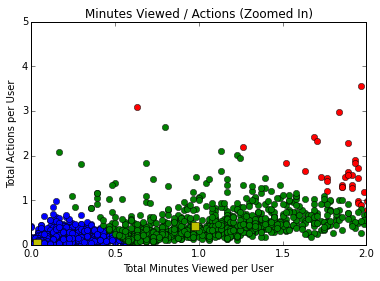

In [332]:
plot(cluster1[idx1==0,0],cluster1[idx1==0,1],'ob',
     cluster1[idx1==1,0],cluster1[idx1==1,1],'or',
     cluster1[idx1==2,0],cluster1[idx1==2,1],'og',
     cluster1[idx1==3,0],cluster1[idx1==3,1],'oy')
plot(centroids1[:,0],centroids1[:,1],'sy',markersize=8)
plt.ylabel('Total Actions per User')
plt.xlabel('Total Minutes Viewed per User')
plt.title('Minutes Viewed / Actions (Zoomed In)')
plt.axis((0,2,0,5))
show()

In [300]:
idx1

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [301]:
len(idx1)

8067

In [314]:
user_table['cluster'] = idx1

In [442]:
user_table['user_level'] = user_table['cluster']
user_table['user_level'] = user_table['user_level'].replace(0,'vlow')
user_table['user_level'] = user_table['user_level'].replace(1,'mid')
user_table['user_level'] = user_table['user_level'].replace(2,'low')
user_table['user_level'] = user_table['user_level'].replace(3,'high')

In [443]:
user_table

,count_per_sesh,count_total,avg_per_sesh,ad_click,ad_completed,ad_error,ad_first_quarter,ad_loaded,ad_mid_point,ad_paused,...,subtitle_change,succeed,sv,timed_comment_change,turing_session,video_blocked,video_load,video_play,cluster,user_level
id,,,,,,,,,,,,,,,,,,,,,
com.viki.android_2014011_e3f133fa-8552-479a-a7d0-d580d13825e9,0,0,0.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,vlow
com.viki.android_202F_0d3dc6ef-a995-4b66-b02e-37efc20e3401,25,286,11.440000,0,0,1,0,1,0,0,...,0,0,12,0,1,0,1,1,0,vlow
com.viki.android_202F_12a48290-106a-473c-a680-5297a2e44c08,26,326,12.538462,0,0,1,0,1,0,0,...,0,0,18,0,1,0,1,1,0,vlow
com.viki.android_304SH_1284d768-fead-4c22-a317-454d57e24372,13,92,7.076923,0,0,0,0,0,0,0,...,0,0,11,0,1,0,0,0,0,vlow
com.viki.android_5038E_ed564b2e-fe09-4167-8424-72f2b2104124,167,23885,143.023952,0,0,28,3,22,1,2,...,0,0,64,0,1,0,26,13,1,mid
com.viki.android_6036Y_128aa2eb-918a-401c-a21a-1122d945149e,61,1744,28.590164,0,0,4,0,5,0,0,...,0,0,21,0,1,0,5,2,0,vlow
com.viki.android_6037Y_2dfdcfb9-39ee-4c98-a2fc-702a44265d54,10,56,5.600000,0,0,0,0,0,0,0,...,0,0,8,0,1,0,0,0,0,vlow
com.viki.android_7040T_ba3e8a93-3701-4bb1-9c3b-7d2f25f73426,237,27611,116.502110,0,12,13,9,10,8,4,...,0,0,56,0,1,0,10,5,2,low
com.viki.android_831C_2c08462d-a3e0-4abf-935a-b273a943e09d,10,56,5.600000,0,0,0,0,0,0,0,...,0,0,9,0,1,0,0,0,0,vlow


In [316]:
print('Number of very low-level users:',sum(user_table['cluster'] == 0))
print('Number of low-level users:',sum(user_table['cluster'] == 2))
print('Number of mid-level users:',sum(user_table['cluster'] == 1))
print('Number of high-level users:',sum(user_table['cluster'] == 3))


Number of very low-level users: 6808
Number of low-level users: 799
Number of mid-level users: 383
Number of high-level users: 77


In [562]:
print('Max Minutes Watched by very-low-level users:',max(user_table['minute_view'][user_table['cluster'] == 0]))
print('Max Minutes Watched by low-level users:',max(user_table['minute_view'][user_table['cluster'] == 2]))
print('Max Minutes Watched by mid-level users:',max(user_table['minute_view'][user_table['cluster'] == 1]))
print('Max Minutes Watched by high-level users:',max(user_table['minute_view'][user_table['cluster'] == 3]))

Max Minutes Watched by very-low-level users: 30
Max Minutes Watched by low-level users: 120
Max Minutes Watched by mid-level users: 370
Max Minutes Watched by high-level users: 746


In [564]:
print('Min Minutes Watched by very-low-level users:',min(user_table['minute_view'][user_table['cluster'] == 0]))
print('Min Minutes Watched by low-level users:',min(user_table['minute_view'][user_table['cluster'] == 2]))
print('Min Minutes Watched by mid-level users:',min(user_table['minute_view'][user_table['cluster'] == 1]))
print('Min Minutes Watched by high-level users:',min(user_table['minute_view'][user_table['cluster'] == 3]))

Min Minutes Watched by very-low-level users: 0
Min Minutes Watched by low-level users: 9
Min Minutes Watched by mid-level users: 34
Min Minutes Watched by high-level users: 176


##Machine Learning Model to predict behavior of new users

####Choose Most Important Features

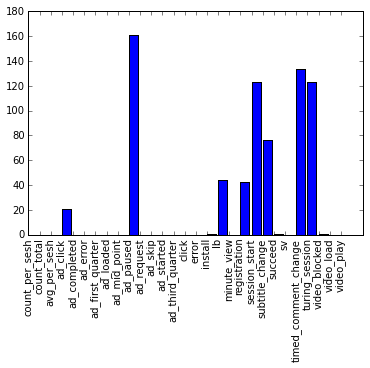

In [317]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

predictors = ['count_per_sesh','count_total','avg_per_sesh', 'ad_click','ad_completed','ad_error','ad_first_quarter','ad_loaded','ad_mid_point','ad_paused','ad_request','ad_skip','ad_started','ad_third_quarter','click','error','install','lb', 'minute_view', 'registration','session_start','subtitle_change','succeed','sv','timed_comment_change','turing_session','video_blocked','video_load','video_play']
# predictors = ['ad_click','ad_completed','ad_error','click','error','install','lb','registration','session_start','subtitle_change','succeed','sv','timed_comment_change','turing_session','video_blocked','video_load','video_play']


# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(user_table[predictors], user_table["cluster"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

# # Pick only the four best features.
# predictors = ["Pclass", "Sex", "Fare", "Title"]

# alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)

####Build Random Forest Model

In [322]:
X = user_table[['ad_click', 'ad_paused', 'minute_view', 'lb', 'registration', 'session_start', 'subtitle_change', 'timed_comment_change', 'turing_session']]
y = user_table['cluster']
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.40)

rfc = sk.RandomForestClassifier(n_estimators=500, oob_score=True, n_jobs = 5 )
model = rfc.fit(X_train, y_train)

In [323]:
rf_test_pred = rfc.predict(X_test)

In [328]:
print("Accuracy = %f" %(skm.accuracy_score(y_test, rf_test_pred)))
print("Precision = %f" %(skm.precision_score(y_test, rf_test_pred)))
print("Recall = %f" %(skm.recall_score(y_test, rf_test_pred)))
print("F1 score = %f" %(skm.f1_score(y_test, rf_test_pred)))
print("Correlation = %f" %(pearsonr(y_test, rf_test_pred)[0]))

Accuracy = 0.986675
Precision = 0.986448
Recall = 0.986675
F1 score = 0.986527
Correlation = 0.960011


/Users/molliepettit/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/molliepettit/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of